In [1]:
''' Import libraries '''
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy import optimize as opt
from IPython.display import display

## Config

In [2]:
path = '/home/phw93/dev/calib/data/*.jpg'

checkboard = [8,6]
boardSize = 0.02

## Functions

In [3]:


def load_images(path):
    """
    images path를 입력받아 load 하고, images와 gray images를 리턴합니다.
    """
    image_files = glob.glob(path)
    image_files = sorted(image_files)
    images = []
    gray_images = []
    for image_file in image_files:
        image = cv2.imread(image_file)
        # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
        images.append(image)
        gray_images.append(gray_image)

    # check 
    images_len = len(gray_images)
    w, h = gray_images[2].shape
    print("Width, Height: ",w, h)
    print("Image len: ", images_len)
    print("Checker board size: ",checkboard[0], checkboard[1])
    print('------')
    
    return images, gray_images
    

In [4]:
def extract_corner_and_NMS(gray_images):
    # extract corner & NMS
    """
    gray image의 corner들을 검출하여 arrCorners Array에 
    [[x1,y1], [x2, x2]... ]로 담아 리턴
    """
    arrCorners = []
    selectedImg = []
    window_size = 3
    half_size = window_size // 2
    winSize = (window_size*2+1, window_size*2+1)
    zeroZone = (-1, -1)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    for gray_image in gray_images:
        max_corners = 100   # 최대 코너 개수
        quality_level = 0.01  # 코너 품질 임계값 (0 ~ 1 사이의 값)
        min_distance = 10  # 검출된 코너 간의 최소 거리
        mask = np.empty((0, 0), dtype=np.float32)
        # corners = cv2.goodFeaturesToTrack(gray_image, max_corners, quality_level, min_distance, mask, blockSize=3, useHarrisDetector=True, k=0.04)
        temp = cv2.convertScaleAbs(gray_image)  # 이미지를 8비트로 변환
        ret, corners = cv2.findChessboardCorners(temp, checkboard, None)
        if ret == True:
            refined_corners = cv2.cornerSubPix(gray_image, corners, winSize, zeroZone, criteria)
            arrCorners.append(refined_corners)
            selectedImg.append(gray_image)
    return selectedImg , arrCorners

In [5]:
def filter_corners(images, arrCorners, threshold, checkboard):
    # draw corners
    filtImg = []
    filtCorners = []
    for image, corners in zip(images, arrCorners):
        if(len(corners)>=(checkboard[0] * checkboard[1] + 3 * (checkboard[0] + checkboard[1]))):
            continue    
        temp = image.copy()
        mean = np.mean(corners, axis=0)
        variance = np.var(corners, axis=0)
        # 분산을 기준으로 일정 이내에 있는 포인트들 필터링
#         threshold = 1.3  # 일정 분산 임계값 (조정 가능)
        filtered_points = []
        for corner in corners:
            if np.all(np.abs(corner - mean) <= threshold * np.sqrt(variance)):
                filtered_points.append(corner)
                x, y = corner[0, 0].astype(int), corner[0, 1].astype(int)
                cv2.drawMarker(temp, (x, y), color=(0, 0, 255), markerType=cv2.MARKER_STAR, markerSize=10, thickness=3)
        if(len(filtered_points) >= checkboard[0]*checkboard[1]-1):
            filtCorners.append(filtered_points)
            filtImg.append(temp)
    
    return filtImg, filtCorners
    

In [15]:
def draw_corners(n, filtImg, filtCorners):
    # 이미지 표시
    plt.imshow(filtImg[n], cmap='gray')
    print("selected images count: ", len(filtCorners))
    print("found corner count: ", len(filtCorners[n]))


### Zhang's method Functions

# Run code

### IMAGE LOAD

In [7]:
images, gray_images = load_images(path)

Width, Height:  1280 720
Image len:  1842
Checker board size:  8 6
------


### Feature extract

In [9]:
gray_images, arrCorners = extract_corner_and_NMS(gray_images)

In [10]:
print(len(gray_images))

1814


### Filtered Checkboard Corner

In [11]:
filtImg, filtCorners = filter_corners(gray_images, arrCorners, 100.5, checkboard)

selected images count:  1814
found corner count:  48


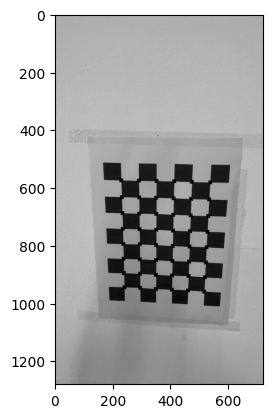

In [18]:
draw_corners(500, filtImg, filtCorners)